# Fit BAO peak from input correlation function

In [1]:
import os
import tempfile
import time
import copy

import numpy as np
import scipy

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams.update({'font.size': 14})

from pycorr import TwoPointCorrelationFunction, TwoPointEstimator, NaturalTwoPointEstimator, project_to_multipoles, project_to_wp, utils, setup_logging
from abacusnbody.data.compaso_halo_catalog import CompaSOHaloCatalog
from cosmoprimo import *

from pk_model import *

# To activate logging
setup_logging()

## Data directory

In [2]:
data_dir = '/feynman/work/dphp/mp270220/outputs/'
output_dir = '/feynman/work/dphp/mp270220/outputs/'

## Load correlation function data

In [3]:
catalog_names = ['AbacusSummit_highbase_c000_ph100_z1.175',
                 'AbacusSummit_base_c000_ph000_z1.175',
                 'AbacusSummit_base_c000_ph000_z0.800']

sim_z = [1.175, 1.175, 0.800]
sim_boxsizes = [1000., 2000., 2000.]

# Import correlation function
rsd = False
rsd_string = ''
if rsd:
    rsd_string = '_wRSD'
else:
    f=0

corrfunc_data_names = [catalog_name+rsd_string+'_corrfunc_randomx6' for catalog_name in catalog_names]

# Simulation to use
sim_index = 0

boxsize = sim_boxsizes[sim_index]
z = sim_z[sim_index]
corrfunc_data_name = corrfunc_data_names[sim_index]

### Global parameters

In [4]:
# Abacus summit base cosmology
cosmo_abacus = fiducial.AbacusSummitBase()
bg = cosmo_abacus.get_background()

f = bg.Omega_m(z)**0.55

# Multipoles (monopole, quadruple, hexadecapole)
ells = [0, 2]
nells = len(ells)

ells_string = 'poles'+''.join([str(ell) for ell in ells])

### Load correlation function poles

In [5]:
result = TwoPointCorrelationFunction.load(data_dir+corrfunc_data_name+'.npy')
s, xiell, cov = result.get_corr(ells=ells, return_sep=True, return_cov=True)
std = np.array_split(np.diag(cov)**0.5, nells)

[000000.03]  04-27 14:15  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/AbacusSummit_highbase_c000_ph100_z1.175_corrfunc_randomx6.npy.
[000001.03]  04-27 14:15  numexpr.utils                INFO     Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
[000001.04]  04-27 14:15  numexpr.utils                INFO     Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[000001.04]  04-27 14:15  numexpr.utils                INFO     NumExpr defaulting to 8 threads.


## Plot multipoles

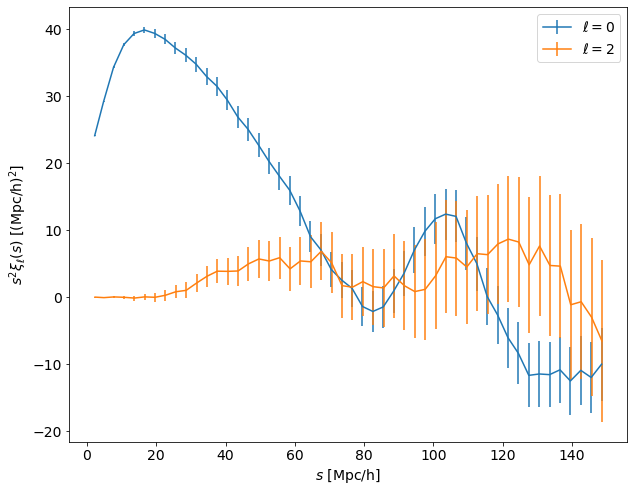

In [6]:
for ill,ell in enumerate(ells):
    plt.errorbar(s+ill*0.1, s**2 * xiell[ill], s**2 * std[ill], fmt='-', label='$\ell = {:d}$'.format(ell))
plt.legend()
plt.xlabel(r'$s$ [Mpc/h]')
plt.ylabel(r'$s^2 \xi_{\ell}(s)$ [$(\mathrm{Mpc}/$h$)^{2}$]')
#plt.ylim(-0.2, 1)
plt.show()

## Generate power spectrum used in the model to fit

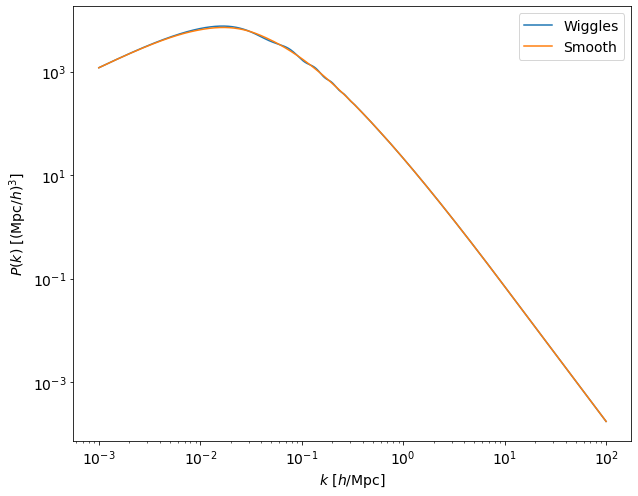

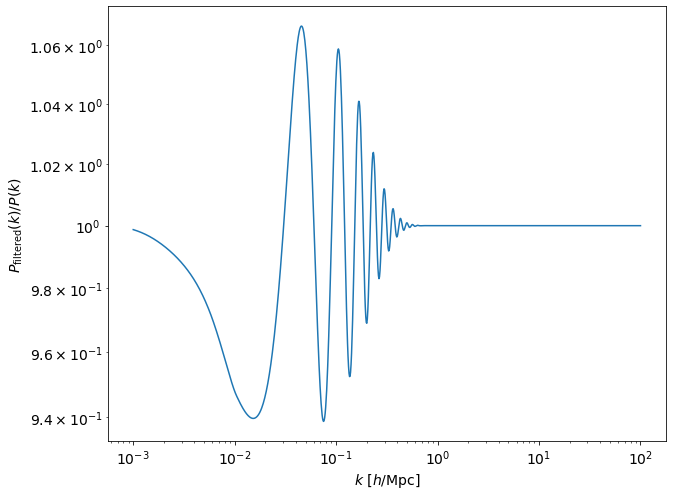

In [7]:
# Whether to include non linear effects
nonlinear = False
nonlinear_string = ''
if nonlinear:
    nonlinear_string = '_nonlinear'

fo = Fourier(cosmo_abacus, engine='camb')
pk = fo.pk_interpolator(nonlinear = nonlinear, extrap_kmin=1e-8, extrap_kmax=1e4).to_1d(z=z)

# BAO filter: extract smoothed power spectrum
pk_smooth = PowerSpectrumBAOFilter(pk, engine='wallish2018').smooth_pk_interpolator()

k = np.logspace(-3,2,1000)

plt.loglog(k, pk(k), label='Wiggles')
plt.loglog(k, pk_smooth(k), label='Smooth')
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.legend()
plt.show()

plt.loglog(k, pk_smooth(k)/pk(k))
plt.xlabel('$k$ [$h/\mathrm{Mpc}$]')
plt.ylabel('$P_{\mathrm{filtered}}(k)/P(k)$')
plt.show()

## Model

[000010.98]  04-27 14:16  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000010.99]  04-27 14:16  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000011.00]  04-27 14:16  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000011.00]  04-27 14:16  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000011.13]  04-27 14:16  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000011.14]  04-27 14:16  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000011.15]  04-27 14:16  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000011.15]  04-27 14:16  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral


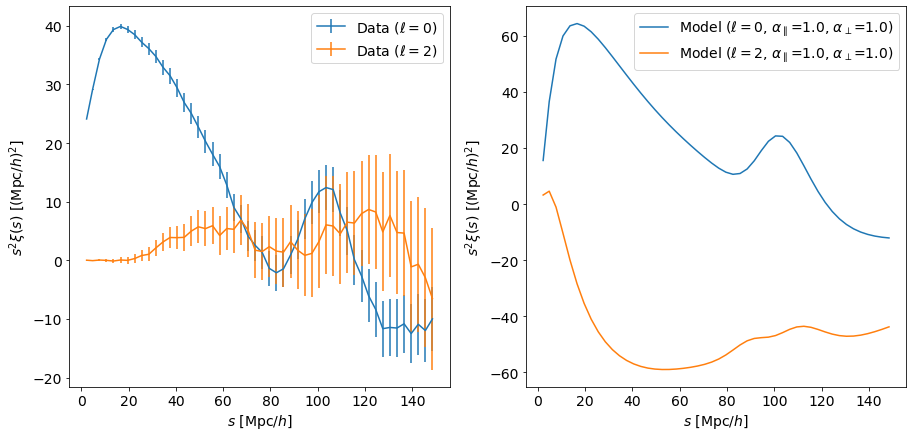

In [8]:
b = 2.
alpha_par = 1.
alpha_perp = 1.

pk_model = pk_model_poles(k, pk_smooth, pk, ells, f, b, alpha_par=alpha_par, alpha_perp=alpha_perp)

# Transform power spectrum model to correlation function model
xi_model = xi_model_poles_interp(k, pk_model, ells)

plt.rcParams["figure.figsize"] = (15, 7)
fig, axes = plt.subplots(1, 2)
                 
for ill,ell in enumerate(ells):
    axes[0].errorbar(s, s**2 * xiell[ill], s**2 * std[ill], fmt='-', label='Data ($\ell = {:d}$)'.format(ell))
    axes[0].legend()
    axes[0].set_xlabel('$s$ [$\mathrm{Mpc}/h$]')
    axes[0].set_ylabel(r'$s^{2}\xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
    
    axes[1].plot(s, s**2 * xi_model[ill](s), label = r'Model ($\ell = {:d}$, '.format(ell)+r'$\alpha_{\parallel}$'+'={:.1f}, '.format(alpha_par) + r'$\alpha_{\perp}$'+'={:.1f})'.format(alpha_perp))
    axes[1].set_xlabel('$s$ [$\mathrm{Mpc}/h$]')
    axes[1].set_ylabel(r'$s^{2}\xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
    axes[1].legend()

plt.show()

plt.rcParams["figure.figsize"] = (10, 8)

In [9]:
def broadband(s, coeffs):
    res = coeffs[0] * s**(-2) + coeffs[1] * s**(-1) + coeffs[2]
    return res

def dil_broadband_fitting_func(s, *args):
    b = args[0]
    broadband_coeffs = args[1:1+nells*3]
    alpha_par = args[nells*3+1]
    alpha_perp = None
    if nells > 1:
        alpha_perp = args[nells*3+2]
    
    pk_model = pk_model_poles(k, pk_smooth, pk, ells, f, b, alpha_par=alpha_par, alpha_perp=alpha_perp)
    
    xi_model = xi_model_poles_interp(k, pk_model, ells)
    
    broadbands = np.concatenate([broadband(s, broadband_coeffs[3*ill:3*(ill+1)]) for ill in range(len(ells))])
    xi_model_poles = np.concatenate([xi_model[ill](s) for ill in range(len(ells))])
    
    return broadbands + xi_model_poles

# Same as above but adding a polynomial broadband
def broadband_fitting_func(s, b, *broadband_coeffs):
    return dil_broadband_fitting_func(s, b, *broadband_coeffs, 1., 1.)

In [10]:
# Remove small scales (linear model not valid at small scales)
lower_s_limit = 50 # Mpc/h
s_truncated = s[s>lower_s_limit]

xiell_truncated_list = list()
cov_list = list()
cov_truncated_list = list()
ns = len(s)

for ill, ell in enumerate(ells):
    xiell_truncated_list.append(xiell[ill][s>lower_s_limit])
    first_index = np.sum(np.logical_not(s>lower_s_limit))
    cov_ell = cov[ill*ns:(ill+1)*ns,ill*ns:(ill+1)*ns]
    cov_list.append(cov_ell)
    cov_truncated_list.append(cov_ell[first_index:, first_index:])
    
xiell_truncated = np.array(xiell_truncated_list)
cov_truncated = np.array(cov_truncated_list)

In [11]:
# Truncate the whole covariance matrix
ns_trunc = len(s_truncated)
cov_truncated_full = np.zeros((ns_trunc*nells, ns_trunc*nells))

for i in range(nells):
    for j in range(nells):
        cov_truncated_full[i*ns_trunc:(i+1)*ns_trunc,j*ns_trunc:(j+1)*ns_trunc] = cov[(i+1)*ns-ns_trunc:(i+1)*ns,(j+1)*ns-ns_trunc:(j+1)*ns]

## Fit model to data

### Bias + damping + broadband

In [12]:
# initialize parameters
p1_init = np.concatenate(([1.], np.tile([0., 0., 0.], nells)))

t1 = time.time()
p1opt, p1cov = scipy.optimize.curve_fit(broadband_fitting_func, s_truncated, xiell_truncated.flatten(), sigma = cov_truncated_full, p0=p1_init)
t2 = time.time()

print('Execution time: {:.2f}'.format(t2-t1))

print('Optimal parameters:')
print(p1opt)

print('Covariance matrix:')
print(p1cov)

print('Sigmas:')
print(np.diag(p1cov)**0.5)

Execution time: 1.52
Optimal parameters:
[ 1.89071430e+00  6.61075374e+00 -4.21714270e-01  2.72502805e-03
  6.37698054e+01  4.22400483e-02 -1.71244232e-03]
Covariance matrix:
[[ 1.84794942e-02 -1.14459745e+00  1.39142104e-02 -3.65305858e-05
   5.91206818e-01 -4.23594820e-03  2.00897283e-05]
 [-1.14459745e+00  1.68744239e+02 -3.26214791e+00  1.46969253e-02
  -4.72118593e+01  5.71681044e-01 -3.10200136e-03]
 [ 1.39142104e-02 -3.26214791e+00  7.26260667e-02 -3.60528259e-04
   6.79705738e-01 -1.01378650e-02  5.51130235e-05]
 [-3.65305858e-05  1.46969253e-02 -3.60528259e-04  1.93194566e-06
  -2.01389853e-03  3.52068579e-05 -1.91123048e-07]
 [ 5.91206818e-01 -4.72118593e+01  6.79705738e-01 -2.01389853e-03
   3.86671792e+02 -9.37141126e+00  5.00433250e-02]
 [-4.23594820e-03  5.71681044e-01 -1.01378650e-02  3.52068579e-05
  -9.37141126e+00  2.41570267e-01 -1.32620443e-03]
 [ 2.00897283e-05 -3.10200136e-03  5.51130235e-05 -1.91123048e-07
   5.00433250e-02 -1.32620443e-03  7.60046876e-06]]
Sigma

In [13]:
output_name = '_'.join([output_dir+corrfunc_data_name+nonlinear_string, ells_string, 'smin{:d}'.format(lower_s_limit)])

In [14]:
np.save(output_name+'_fit_popt', p1opt)
np.save(output_name+'_fit_pcov', p1cov)

In [15]:
p1opt = np.load(output_name+'_fit_popt.npy')
p1cov = np.load(output_name+'_fit_pcov.npy')

### Bias + damping + broadband + dilatation parameters

In [16]:
# initialize parameters
p2_init = np.concatenate(([1.], np.tile([0., 0., 0.], nells)))

if nells == 1:
    p2_init = np.concatenate((p2_init, [1.]))
else:
    p2_init = np.concatenate((p2_init, [1., 1.]))

t1 = time.time()
p2opt, p2cov = scipy.optimize.curve_fit(dil_broadband_fitting_func, s_truncated, xiell_truncated.flatten(), sigma = cov_truncated_full, p0=p2_init)
t2 = time.time()

print('Execution time: {:.2f}'.format(t2-t1))

print('Optimal parameters:')
print(p2opt)

print('Covariance matrix:')
print(p2cov)

print('Sigmas:')
print(np.diag(p2cov)**0.5)

Execution time: 2.03
Optimal parameters:
[ 1.89156311e+00  6.48812337e+00 -4.20069593e-01  2.72266289e-03
  6.25014025e+01  6.30800144e-02 -1.80264791e-03  9.95540772e-01
  1.00238447e+00]
Covariance matrix:
[[ 1.92933764e-02 -1.17261625e+00  1.42596279e-02 -3.70333727e-05
   5.88127186e-01 -4.09940439e-03  1.92405994e-05  1.23500830e-04
   1.12415023e-04]
 [-1.17261625e+00  1.75818851e+02 -3.38977075e+00  1.52621233e-02
  -4.48702254e+01  5.20207061e-01 -2.92432189e-03  1.91363471e-02
   3.67965076e-03]
 [ 1.42596279e-02 -3.38977075e+00  7.53071461e-02 -3.73612076e-04
   6.51852217e-01 -9.57204915e-03  5.33325864e-05 -2.42188679e-04
  -3.81106546e-05]
 [-3.70333727e-05  1.52621233e-02 -3.73612076e-04  2.00137607e-06
  -1.98228869e-03  3.43965496e-05 -1.90328460e-07  7.78143264e-07
   3.89612566e-07]
 [ 5.88127186e-01 -4.48702254e+01  6.51852217e-01 -1.98228869e-03
   4.29282191e+02 -1.01814263e+01  5.38639317e-02  1.11470526e-01
  -5.27197314e-02]
 [-4.09940439e-03  5.20207061e-01 -9.

In [17]:
np.save(output_name+'_AP_fit_popt', p2opt)
np.save(output_name+'_AP_fit_pcov', p2cov)

In [18]:
p2opt = np.load(output_name+'_AP_fit_popt.npy')
p2cov = np.load(output_name+'_AP_fit_pcov.npy')

In [19]:
model_broadband = broadband_fitting_func(s, *p1opt)
model_broadband_dil = dil_broadband_fitting_func(s, *p2opt)

### Compute $\chi^2$

In [20]:
def compute_chisq(xdata, ydata, sigma, fitted_model):
    r = ydata - fitted_model
    
    chisq = r.T @ np.linalg.inv(sigma) @ r
    
    return chisq

In [21]:
chisq_list = list()
chisq_AP_list = list()

for ill,ell in enumerate(ells):
    chisq = compute_chisq(s_truncated, xiell_truncated[ill], cov_truncated[ill], model_broadband[ill*ns:(ill+1)*ns][s>lower_s_limit])
    chisq_AP = compute_chisq(s_truncated, xiell_truncated[ill], cov_truncated[ill], model_broadband_dil[ill*ns:(ill+1)*ns][s>lower_s_limit])
    chisq_list.append(chisq)
    chisq_AP_list.append(chisq_AP)

    print("Chi square per degree of freedom :")
    print('l = {}'.format(ells[ill]))
    print("Mdel without A&P effect: {:.2f}".format(chisq/(ns_trunc-(1+3*nells))))
    if nells > 1:
        print("Mdel with A&P effect: {:.2f}".format(chisq_AP/(ns_trunc-(1+3*nells+2))))
    else:
        print("Mdel with A&P effect: {:.2f}".format(chisq_AP/(ns_trunc-(1+3*nells+1))))

Chi square per degree of freedom :
l = 0
Mdel without A&P effect: 1.32
Mdel with A&P effect: 1.43
Chi square per degree of freedom :
l = 2
Mdel without A&P effect: 1.06
Mdel with A&P effect: 1.14


[000015.48]  04-27 14:16  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000015.49]  04-27 14:16  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000015.59]  04-27 14:16  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral
[000015.59]  04-27 14:16  matplotlib.mathtext          INFO     Substituting symbol \perp from STIXGeneral


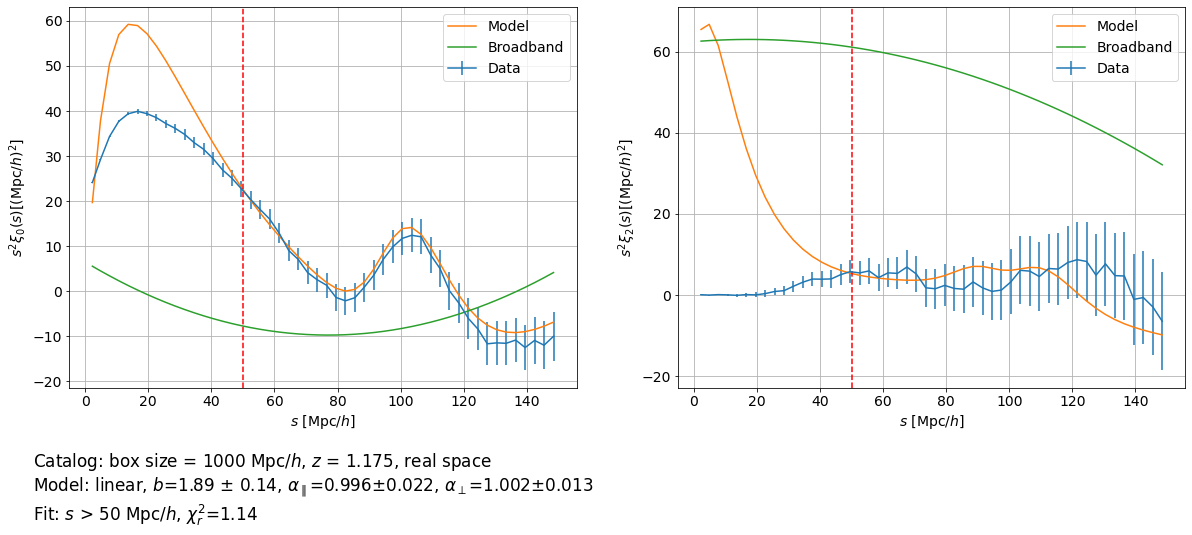

In [22]:
rsd_info = 'real space'
if rsd:
    rsd_info = 'redshift space'

linear_info = 'linear'    
if nonlinear:
    linear_info = 'non linear'

plt.rcParams["figure.figsize"] = (20, 7)

if nells > 1:
    fig, axes = plt.subplots(1, nells)

    for ill, ell in enumerate(ells):
        axes[ill].errorbar(s, s**2 * xiell[ill], s**2 * std[ill], fmt='-', label='Data')
        axes[ill].plot(s, s**2 * model_broadband_dil[ill*ns:(ill+1)*ns], label = 'Model')
        axes[ill].plot(s, s**2 * broadband(s, p2opt[1+3*ill:1+3*(ill+1)]), label = 'Broadband')
        axes[ill].axvline(lower_s_limit, linestyle='dashed', color='r')
        axes[ill].grid(True)
        axes[ill].legend()    
        axes[ill].set_xlabel('$s$ [$\mathrm{Mpc}/h$]')
        axes[ill].set_ylabel(r'$s^2\xi_{}(s)$'.format(ell)+r'[$(\mathrm{Mpc}/h)^{2}$]')

    fig.suptitle('Catalog: box size = {:.0f} Mpc/$h$, $z$ = {:.3f}, '.format(boxsize, z) + rsd_info 
                 + '\n' + 'Model: ' + linear_info + ', $b$={:.2f} $\pm$ {:.2f}, '.format(p2opt[0], np.diag(p2cov)[0]**0.5)+r'$\alpha_{\parallel}$'+'={:.3f}'.format(p2opt[1+3*nells]) +'$\pm$'+ '{:.3f}'.format(np.diag(p2cov)[1+3*nells]**0.5) + r', $\alpha_{\perp}$'+'={:.3f}'.format(p2opt[1+3*nells+1]) +'$\pm$'+ '{:.3f}'.format(np.diag(p2cov)[1+3*nells+1]**0.5)
                 + '\n'  'Fit: $s$ > {:.0f} Mpc/$h$, '.format(lower_s_limit) + r'$\chi^2_{r}$=' +'{:.2f}'.format(chisq_AP_list[ill]/(ns_trunc-(1+3*nells+2))), 
                 ha='left', x=0.1, y=0)
    plt.show()

else:
    plt.rcParams["figure.figsize"] = (10, 7)

    ill = 0
    plt.errorbar(s, s**2 * xiell[ill], s**2 * std[ill], fmt='-', label='Data')
    plt.plot(s, s**2 * model_broadband_dil[ill*ns:(ill+1)*ns], label = r'Model')
    plt.plot(s, s**2 * broadband(s, p2opt[1+3*ill:1+3*(ill+1)]), label = 'Broadband')
    plt.axvline(lower_s_limit, linestyle='dashed', color='r')
    plt.grid(True)
    plt.legend()    
    plt.xlabel('$s$ [$\mathrm{Mpc}/h$]')
    plt.ylabel(r'$s^2\xi_{}(s)$'.format(ell)+r'[$(\mathrm{Mpc}/h)^{2}$]')

    plt.suptitle('Catalog: box size = {:.0f} Mpc/$h$, $z$ = {:.3f}, '.format(boxsize, z) + rsd_info 
                 + '\n' + 'Model: ' + linear_info + ', $b$={:.2f} $\pm$ {:.2f}, '.format(p2opt[0], np.diag(p2cov)[0]**0.5)+r'$\alpha_{\parallel}=\alpha_{\perp}$'+'={:.3f}'.format(p2opt[1+3*nells]) +'$\pm$'+ '{:.3f}'.format(np.diag(p2cov)[1+3*nells]**0.5)
                 + '\n'  'Fit: $s$ > {:.0f} Mpc/$h$, '.format(lower_s_limit) + r'$\chi^2_{r}$=' +'{:.2f}'.format(chisq_AP_list[ill]/(ns_trunc-(1+3*nells+1))), 
                 ha='left', x=0.1, y=0)
    plt.show()
    

In [24]:
xiell_1 = copy.deepcopy(xiell[0])
std_1 = copy.deepcopy(std[0])
p2opt_1 = copy.deepcopy(p2opt)
model_broadband_dil_1 = copy.deepcopy(model_broadband_dil)

In [47]:
xiell_2 = copy.deepcopy(xiell[0])
std_2 = copy.deepcopy(std[0])
p2opt_2 = copy.deepcopy(p2opt)
model_broadband_dil_2 = copy.deepcopy(model_broadband_dil)

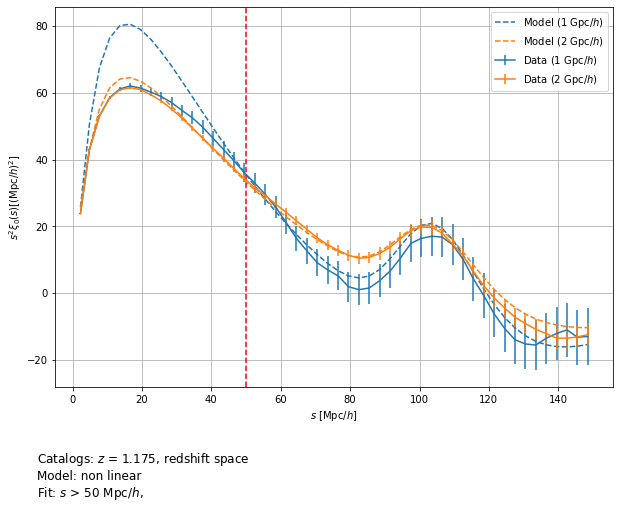

In [51]:
ill = 0
plt.errorbar(s, s**2 * xiell_1, s**2 * std_1, fmt='-', label='Data (1 Gpc/$h$)', color='C0')
plt.plot(s, s**2 * model_broadband_dil_1[ill*ns:(ill+1)*ns], label = r'Model (1 Gpc/$h$)', color='C0', linestyle='dashed')
plt.errorbar(s, s**2 * xiell_2, s**2 * std_2, fmt='-', label='Data (2 Gpc/$h$)', color='C1')
plt.plot(s, s**2 * model_broadband_dil_2[ill*ns:(ill+1)*ns], label = r'Model (2 Gpc/$h$)', color='C1', linestyle='dashed')
plt.axvline(lower_s_limit, linestyle='dashed', color='r')
plt.grid(True)
plt.legend()    
plt.xlabel('$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2\xi_{}(s)$'.format(ell)+r'[$(\mathrm{Mpc}/h)^{2}$]')
plt.suptitle('Catalogs: $z$ = {:.3f}, '.format(z) + rsd_info 
             + '\n' + 'Model: ' + linear_info
             + '\n'  'Fit: $s$ > {:.0f} Mpc/$h$, '.format(lower_s_limit), 
             ha='left', x=0.1, y=0)
plt.show()


In [44]:
xiell_real = copy.deepcopy(xiell[0])
std_real = copy.deepcopy(std[0])
p2opt_real = copy.deepcopy(p2opt)
model_broadband_dil_real = copy.deepcopy(model_broadband_dil)

In [23]:
xiell_redshift = copy.deepcopy(xiell[0])
std_redshift = copy.deepcopy(std[0])
p2opt_redshift = copy.deepcopy(p2opt[0])
model_broadband_dil_redshift = copy.deepcopy(model_broadband_dil)

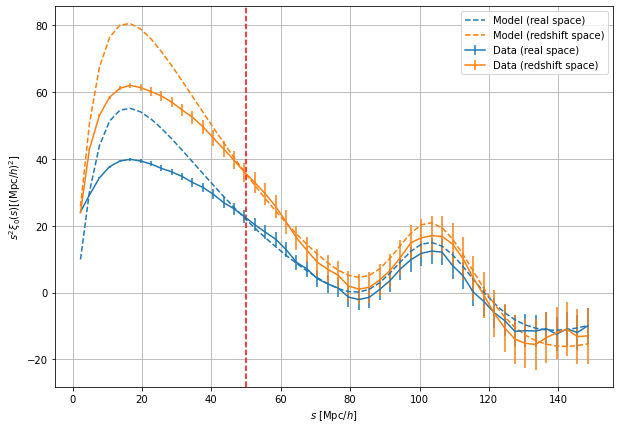

In [50]:
ill = 0
plt.errorbar(s, s**2 * xiell_real, s**2 * std_real, fmt='-', label='Data (real space)', color='C0')
plt.errorbar(s, s**2 * xiell_redshift, s**2 * std_redshift, fmt='-', label='Data (redshift space)', color='C1')
plt.plot(s, s**2 * model_broadband_dil_real[ill*ns:(ill+1)*ns], label = r'Model (real space)', color='C0', linestyle='dashed')
plt.plot(s, s**2 * model_broadband_dil_redshift[ill*ns:(ill+1)*ns], label = r'Model (redshift space)', color='C1', linestyle='dashed')
plt.axvline(lower_s_limit, linestyle='dashed', color='r')
plt.grid(True)
plt.legend()    
plt.xlabel('$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2\xi_{}(s)$'.format(ell)+r'[$(\mathrm{Mpc}/h)^{2}$]')
plt.show()    